In [2]:
from preprocessing_utils import *
import os
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

In [3]:
df_stats = get_game_data()

wins = df_stats.loc[df_stats['Team1 result'] == 'win']
# wins = wins.sample(n=36)
loss = df_stats.loc[df_stats['Team1 result'] == 'loss']
# df_stats = pd.concat([wins, loss])
Y = df_stats['Team1 result']
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y)

df_stats = df_stats.loc[:, df_stats.columns.str.contains('Norm')]
df_stats = df_stats.drop(['Seed Norm Diff'], axis=1)

In [4]:
wins.shape

(282, 37)

In [5]:
df_stats.shape

(567, 14)

In [6]:
df_stats.columns

Index(['W-L% Norm Diff', 'SOS Norm Diff', 'ORtg Norm Diff', 'DRtg Norm Diff',
       'FG% Norm Diff', 'WL% * SOS Norm Diff', '3P% Norm Diff',
       'FT% Norm Diff', 'PPG Norm Diff', 'OPPG Norm Diff', 'APG Norm Diff',
       'TOVPG Norm Diff', 'Adjusted WL% Norm Diff',
       'Adjusted Margin Norm Diff'],
      dtype='object')

In [7]:
df_stats[0:5]

,W-L% Norm Diff,SOS Norm Diff,ORtg Norm Diff,DRtg Norm Diff,FG% Norm Diff,WL% * SOS Norm Diff,3P% Norm Diff,FT% Norm Diff,PPG Norm Diff,OPPG Norm Diff,APG Norm Diff,TOVPG Norm Diff,Adjusted WL% Norm Diff,Adjusted Margin Norm Diff
0,-1.613043,-0.792023,-0.992063,-0.391076,-0.978743,-0.899400,-1.393613,-0.211531,-0.914089,-0.222661,-1.658315,-0.299235,-1.450358,-1.447090
1,-0.416377,0.092479,-0.694517,-0.184744,-0.761990,0.046731,-1.574169,1.000000,-0.613461,0.065404,-0.932886,-0.667815,-0.373061,-0.990717
2,-0.076894,0.547085,-0.735043,0.614183,-0.846106,0.656215,-1.155321,-0.463242,-1.555676,0.453065,-0.258670,0.352127,-0.131809,-0.308208
3,-0.077640,0.989772,0.386843,-0.072451,0.089620,1.064504,0.138564,0.792517,-0.368882,0.217483,-0.372252,0.487717,-0.269568,0.319186
4,0.482289,-0.047339,-0.198737,0.302416,-0.042514,0.007836,-1.077005,-0.191836,0.476117,-0.516756,-0.204680,-0.464562,0.672271,-0.021924


In [8]:
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(df_stats)
# X = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4'])
X = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14'])

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 14 columns):
PC1     567 non-null float64
PC2     567 non-null float64
PC3     567 non-null float64
PC4     567 non-null float64
PC5     567 non-null float64
PC6     567 non-null float64
PC7     567 non-null float64
PC8     567 non-null float64
PC9     567 non-null float64
PC10    567 non-null float64
PC11    567 non-null float64
PC12    567 non-null float64
PC13    567 non-null float64
PC14    567 non-null float64
dtypes: float64(14)
memory usage: 62.1 KB


In [10]:
X[0:5]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-3.812953,0.001216,-0.323769,0.604977,0.019400,-0.203312,0.026274,0.487845,0.616140,0.037627,-0.024752,0.197650,0.104827,0.011297
1,-1.925220,-0.488924,-0.710458,0.612314,-1.480071,-0.147877,-0.058816,0.354898,-0.201330,-0.165926,-0.183985,0.177803,-0.058405,0.033032
2,-1.108484,-2.030853,-0.736580,-0.028974,0.020174,-0.019185,0.508958,0.127384,-0.583453,0.214530,0.368134,0.097634,-0.031247,-0.081408
3,0.750251,-0.517997,-1.434833,0.770780,-0.087236,0.347226,-0.094349,0.207712,0.161577,-0.158942,0.236577,-0.069516,-0.015409,-0.066967
4,-0.046420,-0.290762,0.405333,-0.648535,-0.917404,-0.876363,-0.422618,0.199578,-0.103165,0.193305,0.069017,0.111965,0.043606,0.001984


In [11]:
class Network(nn.Module):
    def __init__(self, isTraining = True):
        super().__init__()
        
        nfeatures = 14
        self.isTraining = isTraining
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(nfeatures, 256)
        self.hidden1 = nn.Linear(256, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 1)
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.7, training=self.isTraining)
        x = self.hidden1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.7, training=self.isTraining)
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

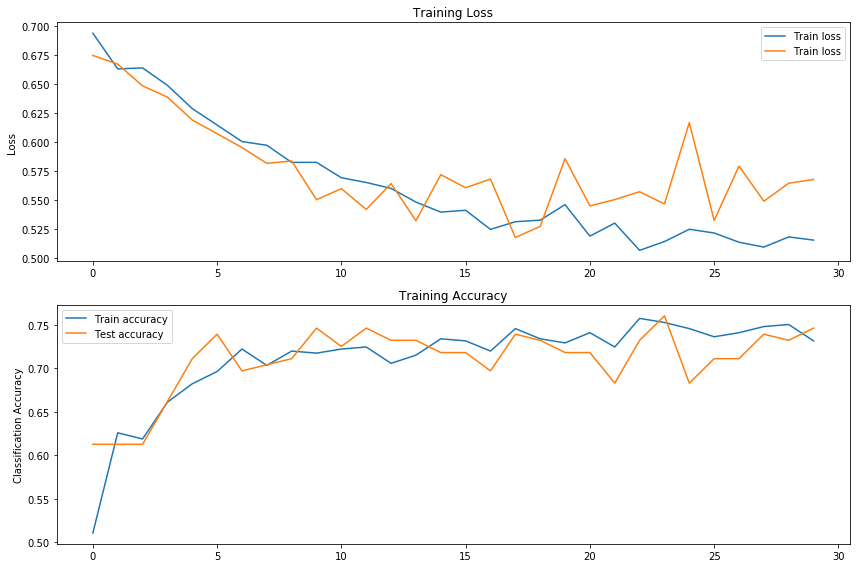

Train Accuracy 0.7576


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=73)
X_train, X_test = X_train.values, X_test.values

model = Network(isTraining=True)

loss_func = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
iters = 30
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
Y_test_t = torch.FloatTensor(Y_test).reshape(-1, 1)
for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = model(X_train_t)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_train.reshape(-1,1)==y_hat_class) / len(Y_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
    X_test_t = torch.FloatTensor(X_test)
    y_hat = model(X_test_t)
    loss = loss_func(y_hat, Y_test_t)
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_class) / len(Y_test)
    test_accuracy.append(accuracy)
    test_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss, label='Train loss')
ax[0].plot(test_loss, label='Train loss')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

ax[1].plot(train_accuracy, label='Train accuracy')
ax[1].plot(test_accuracy, label='Test accuracy')
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()
print("Train Accuracy {:.4f}".format(max(train_accuracy)))

In [24]:
model.isTraining = False
X_test_t = torch.FloatTensor(X_test)
y_hat_test = model(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

Test Accuracy 0.74


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_hat_test_class)

array([[52, 26],
       [11, 53]])